
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Deep Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Fall 2024<br>
<font color=3C99D size=5>
Project <br>
<font color=696880 size=4>
<!-- <br> -->


____

<font color=2565AE size=6>
Parsa Hatami <br>
<font color=2565AE size=6>
400100962 <br>

____

## Install Requirments

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 22.1 MB/s eta 0:00:0000:01


## Libraries

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import cv2
from ultralytics import YOLO

## Dataset Preparation and Data Preprocessing

In [ ]:
dataset_root = "/kaggle/input/sportsmot/sportsmot_publish/dataset"
splits_root = "/kaggle/input/sportsmot/sportsmot_publish/splits_txt"
output_root = "/kaggle/working/yolo_dataset"

IMAGE_EXT = ".jpg"
LABEL_EXT = ".txt"

Convert to YOLO input format, normalizing, preprocessing and making yaml file

In [2]:
def get_football_sequences(football_file_path):
    with open(football_file_path, "r") as file:
        return set(line.strip() for line in file)

def create_directories(output_dir):
    dirs = [
        "train/images", "train/labels",
        "val/images", "val/labels"
    ]
    for dir_path in dirs:
        os.makedirs(os.path.join(output_dir, dir_path), exist_ok=True)

def parse_seqinfo(seqinfo_path):
    """Parses seqinfo.ini to get image width and height."""
    img_width, img_height = None, None
    with open(seqinfo_path, "r") as f:
        for line in f:
            if "imWidth" in line:
                img_width = int(line.split('=')[1].strip())
            elif "imHeight" in line:
                img_height = int(line.split('=')[1].strip())
    return img_width, img_height

def normalize_bbox(x, y, w, h, img_width, img_height):
    """Normalizes bounding box coordinates."""
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

def process_ground_truth(gt_file, img_width, img_height):
    annotations = []
    with open(gt_file, "r") as f:
        for line in f:
            parts = line.strip().split(',')
            frame_id, class_id, x, y, w, h = map(float, parts[:6])
            x_center, y_center, norm_w, norm_h = normalize_bbox(x, y, w, h, img_width, img_height)
            annotations.append((int(frame_id), int(class_id - 1), x_center, y_center, norm_w, norm_h))
    return annotations

def save_annotations_and_images(sequence_path, annotations, split, output_dir):
    for frame_id, class_id, x_center, y_center, norm_w, norm_h in annotations:
        img_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}{IMAGE_EXT}"
        label_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}{LABEL_EXT}"

        img_src = os.path.join(sequence_path, "img1", f"{frame_id:06d}{IMAGE_EXT}")
        img_dst = os.path.join(output_dir, split, "images", img_name)
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)

        # Write label file in YOLO format
        label_dst = os.path.join(output_dir, split, "labels", label_name)
        with open(label_dst, "w") as label_file:
            label_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")

def convert_sequence(sequence_path, split, output_dir, football_sequences):
    if os.path.basename(sequence_path) not in football_sequences:
        return

    seqinfo_path = os.path.join(sequence_path, "seqinfo.ini")
    img_width, img_height = parse_seqinfo(seqinfo_path)
    
    gt_file = os.path.join(sequence_path, "gt/gt.txt")
    annotations = process_ground_truth(gt_file, img_width, img_height)

    save_annotations_and_images(sequence_path, annotations, split, output_dir)

def process_splits(splits_file, split, output_dir, football_sequences):
    with open(splits_file, "r") as f:
        sequences = [line.strip() for line in f]

    for seq in sequences:
        sequence_path = os.path.join(dataset_root, split, seq)
        if os.path.exists(sequence_path):
            convert_sequence(sequence_path, split, output_dir, football_sequences)

In [4]:
football_sequences = get_football_sequences(os.path.join(splits_root, "football.txt"))
create_directories(output_root)

for split in ["train", "val"]:
    splits_file = os.path.join(splits_root, f"{split}.txt")
    process_splits(splits_file, split, output_root, football_sequences)

print(f"Process has been completed. YOLO dataset is saved at: {output_root}")

Process has been completed. YOLO dataset is saved at: /kaggle/working/yolo_dataset


Creating yaml file

In [ ]:
dataset_path = "/kaggle/working/yolo_dataset"
train_images = os.path.join(dataset_path, "train/images")
val_images = os.path.join(dataset_path, "val/images")
train_labels = os.path.join(dataset_path, "train/labels")
val_labels = os.path.join(dataset_path, "val/labels")

In [3]:
data_yaml = f"""
path: {dataset_path}  # Root dataset path
train: {train_images}  # Training images directory
val: {val_images}  # Validation images directory

# Number of classes (update this if needed)
nc: 1  # Change this if your dataset has multiple object classes

# Class names (update accordingly)
names: ["football"]  # Modify if there are multiple classes
"""

# Save data.yaml
yaml_path = os.path.join(dataset_path, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print(f"✅ data.yaml file created at {yaml_path}")


✅ data.yaml file created at /kaggle/working/yolo_dataset/data.yaml


## Implementation of Object Tracking Algorithm

In [4]:
dataset_path = "/kaggle/working/yolo_dataset"
model_path = "/kaggle/working/runs/train/yolov8_best.pt"

# Load YOLOv8 model
model = YOLO("yolov8n.pt")

model.train(
    data=f"{dataset_path}/data.yaml",
    epochs=50,
    imgsz=720,  # Set image size to 720p
    batch=16,
    workers=2,
    device="cuda"
)

print(f"✅ Training started with dataset: {dataset_path}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 131MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=720, save=True, save_period=-1, cache=False, device=cuda, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 26.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 101MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]


train: Scanning /kaggle/working/yolo_dataset/train/labels... 11113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11113/11113 [00:09<00:00, 1135.13it/s]


train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo_dataset/val/labels... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:08<00:00, 1123.03it/s]

val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000499.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000500.jpg: 1

val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.12G     0.9134      0.752      0.865        192        736: 100%|██████████| 695/695 [02:54<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:57<00:00,  4.91it/s]


                   all       9058     117024       0.89      0.927      0.932      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.15G     0.8136     0.4682     0.8457        229        736: 100%|██████████| 695/695 [02:49<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.18it/s]


                   all       9058     117024        0.9      0.938      0.937      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.08G     0.7898     0.4353     0.8401        235        736: 100%|██████████| 695/695 [02:48<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.27it/s]


                   all       9058     117024      0.899      0.936       0.94      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.23G     0.7703     0.4166     0.8367        174        736: 100%|██████████| 695/695 [02:49<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.27it/s]


                   all       9058     117024      0.893      0.886      0.928      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.16G     0.7438     0.3994     0.8329        246        736: 100%|██████████| 695/695 [02:47<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.26it/s]


                   all       9058     117024      0.914       0.93      0.929      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.16G     0.7235     0.3848     0.8293        173        736: 100%|██████████| 695/695 [02:48<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.33it/s]


                   all       9058     117024      0.924      0.924      0.953      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       3.2G     0.7158     0.3788     0.8267        280        736: 100%|██████████| 695/695 [02:47<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.24it/s]


                   all       9058     117024      0.916      0.898      0.937      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.16G     0.7034     0.3701     0.8259        167        736: 100%|██████████| 695/695 [02:48<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.18it/s]


                   all       9058     117024      0.912      0.908      0.935      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.16G     0.6928      0.362     0.8233        204        736: 100%|██████████| 695/695 [02:48<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:55<00:00,  5.14it/s]


                   all       9058     117024      0.918      0.953       0.94      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.19G     0.6869     0.3583     0.8223        273        736: 100%|██████████| 695/695 [02:48<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.21it/s]


                   all       9058     117024      0.916      0.929      0.945      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.16G     0.6779     0.3532     0.8221        246        736: 100%|██████████| 695/695 [02:48<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.18it/s]


                   all       9058     117024      0.919      0.928      0.943      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.16G      0.672     0.3486     0.8201        251        736: 100%|██████████| 695/695 [02:48<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.22it/s]


                   all       9058     117024      0.917      0.939      0.941      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.15G     0.6605     0.3426     0.8191        187        736: 100%|██████████| 695/695 [02:47<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:55<00:00,  5.09it/s]


                   all       9058     117024      0.921      0.944      0.943      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.18G     0.6597     0.3402     0.8186        199        736: 100%|██████████| 695/695 [02:48<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.21it/s]


                   all       9058     117024      0.917      0.943      0.937      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.19G     0.6572     0.3372     0.8182        136        736: 100%|██████████| 695/695 [02:47<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.21it/s]


                   all       9058     117024      0.911      0.947      0.933      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.19G     0.6497     0.3333     0.8174        180        736: 100%|██████████| 695/695 [02:47<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.20it/s]


                   all       9058     117024      0.923      0.932      0.944      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.19G      0.643      0.328     0.8156        300        736: 100%|██████████| 695/695 [02:48<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.25it/s]


                   all       9058     117024      0.927      0.947      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.17G     0.6385      0.326     0.8148        255        736: 100%|██████████| 695/695 [02:46<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.26it/s]


                   all       9058     117024      0.925      0.941      0.943      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.16G     0.6361     0.3232      0.816        219        736: 100%|██████████| 695/695 [02:47<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.37it/s]


                   all       9058     117024      0.918      0.931      0.929      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.23G     0.6311     0.3202     0.8145        214        736: 100%|██████████| 695/695 [02:47<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.31it/s]


                   all       9058     117024      0.918       0.94      0.938      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.17G     0.6298     0.3194     0.8143        181        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.30it/s]


                   all       9058     117024      0.919      0.944      0.939      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.15G     0.6242     0.3166     0.8138        149        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.35it/s]


                   all       9058     117024      0.917      0.939      0.932      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.19G     0.6224     0.3142     0.8125        232        736: 100%|██████████| 695/695 [02:46<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.33it/s]


                   all       9058     117024      0.926      0.942      0.944      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.17G     0.6165     0.3105     0.8125        189        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.33it/s]


                   all       9058     117024      0.923      0.939      0.941      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.14G     0.6156     0.3096     0.8121        182        736: 100%|██████████| 695/695 [02:47<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.36it/s]


                   all       9058     117024      0.923      0.946      0.942      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.06G     0.6123     0.3078     0.8111        255        736: 100%|██████████| 695/695 [02:46<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.36it/s]


                   all       9058     117024      0.924      0.939      0.934      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.13G     0.6085     0.3052     0.8106        227        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.36it/s]


                   all       9058     117024      0.922      0.943      0.941      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.16G     0.6052     0.3024     0.8096        202        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.35it/s]


                   all       9058     117024      0.921      0.937      0.939      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.16G     0.6028     0.3011     0.8098        185        736: 100%|██████████| 695/695 [02:45<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.32it/s]


                   all       9058     117024      0.925      0.942      0.942      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.16G     0.6006     0.2993     0.8096        171        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.35it/s]


                   all       9058     117024      0.919      0.935      0.936      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.15G     0.5966     0.2974     0.8087        164        736: 100%|██████████| 695/695 [02:47<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.37it/s]


                   all       9058     117024      0.919      0.936      0.935      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.16G     0.5953     0.2956     0.8096        218        736: 100%|██████████| 695/695 [02:46<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.35it/s]


                   all       9058     117024      0.919      0.942      0.939      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.16G     0.5921     0.2947     0.8085        209        736: 100%|██████████| 695/695 [02:47<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.32it/s]


                   all       9058     117024      0.923      0.939       0.94      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.17G     0.5892     0.2918     0.8079        263        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.34it/s]


                   all       9058     117024       0.92      0.939       0.94      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.15G     0.5879     0.2912     0.8067        219        736: 100%|██████████| 695/695 [02:46<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.32it/s]


                   all       9058     117024      0.924       0.94      0.942      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.15G     0.5835     0.2878      0.806        238        736: 100%|██████████| 695/695 [02:47<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.31it/s]


                   all       9058     117024       0.92      0.941      0.942      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.14G     0.5801     0.2856     0.8057        247        736: 100%|██████████| 695/695 [02:45<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.34it/s]


                   all       9058     117024      0.922      0.945      0.941      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.15G     0.5784     0.2849     0.8059        232        736: 100%|██████████| 695/695 [02:46<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.37it/s]


                   all       9058     117024      0.921      0.943      0.939      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.13G     0.5765     0.2836     0.8061        146        736: 100%|██████████| 695/695 [02:46<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.38it/s]


                   all       9058     117024      0.923      0.944      0.939      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.19G     0.5736     0.2816      0.805        245        736: 100%|██████████| 695/695 [02:46<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.33it/s]


                   all       9058     117024      0.921      0.938      0.941      0.787
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.78G     0.5401     0.2658     0.8016        125        736: 100%|██████████| 695/695 [02:43<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.35it/s]


                   all       9058     117024      0.919      0.934      0.933      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.8G     0.5349     0.2626     0.8003        105        736: 100%|██████████| 695/695 [02:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.39it/s]


                   all       9058     117024      0.919      0.941      0.932      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.79G     0.5333     0.2601     0.8003        100        736: 100%|██████████| 695/695 [02:41<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.35it/s]


                   all       9058     117024       0.92      0.939      0.935       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.79G     0.5289     0.2568     0.7998        101        736: 100%|██████████| 695/695 [02:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.36it/s]


                   all       9058     117024      0.919      0.932      0.933      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.78G     0.5259     0.2543     0.7989        102        736: 100%|██████████| 695/695 [02:41<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:52<00:00,  5.41it/s]


                   all       9058     117024      0.918      0.933      0.934      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.8G     0.5215     0.2531     0.7978        117        736: 100%|██████████| 695/695 [02:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.34it/s]


                   all       9058     117024      0.918      0.935      0.934      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.79G     0.5188     0.2499     0.7973        116        736: 100%|██████████| 695/695 [02:41<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.31it/s]


                   all       9058     117024       0.92      0.937      0.934      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.79G     0.5157      0.248     0.7972        103        736: 100%|██████████| 695/695 [02:41<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.35it/s]


                   all       9058     117024      0.916      0.937      0.931      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.78G     0.5146     0.2467     0.7964        127        736: 100%|██████████| 695/695 [02:41<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:53<00:00,  5.30it/s]


                   all       9058     117024      0.917      0.937      0.933      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.8G     0.5119      0.244     0.7967        121        736: 100%|██████████| 695/695 [02:43<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:54<00:00,  5.26it/s]


                   all       9058     117024      0.917      0.938      0.933      0.778

50 epochs completed in 3.073 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:09<00:00,  4.10it/s]


                   all       9058     117024      0.927      0.946      0.952      0.791


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train
✅ Training started with dataset: /kaggle/working/yolo_dataset


Saving model and results

In [5]:
shutil.make_archive("/kaggle/working/yolov8_results", 'zip', "/kaggle/working/runs/detect/train/")
print("✅ All training results saved as a ZIP file: /kaggle/working/yolov8_results.zip")

✅ All training results saved as a ZIP file: /kaggle/working/yolov8_results.zip


Save CSV File of the results

Reading columns in results

In [10]:
# Load training results CSV
log_path = "/kaggle/working/runs/detect/train/results.csv"
df = pd.read_csv(log_path)

# Print available columns
print("Columns in results.csv:", df.columns.tolist())

Columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Plot accuracy and loss curves

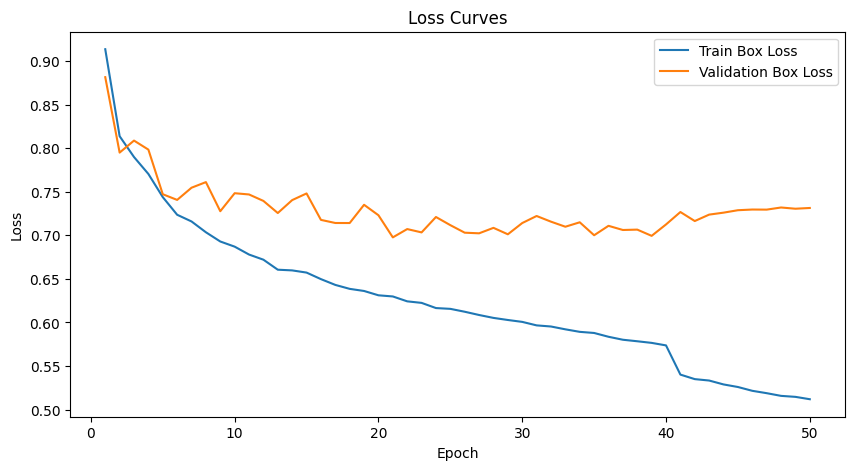

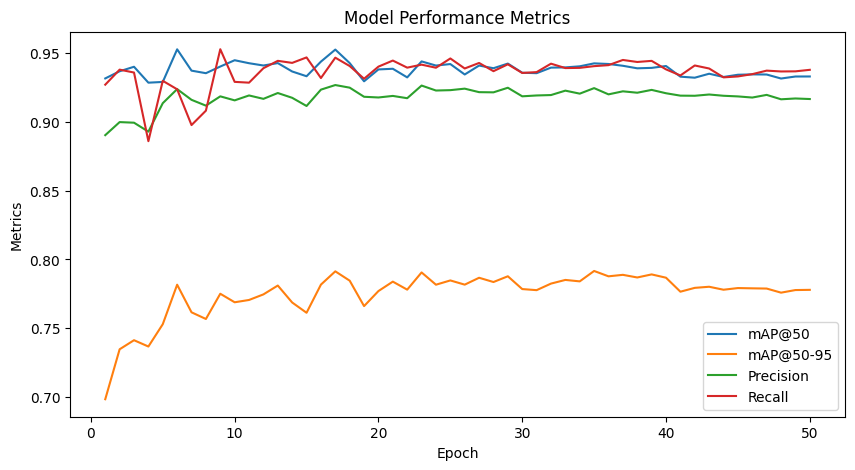

In [9]:
log_path = "/kaggle/working/runs/detect/train/results.csv"
df = pd.read_csv(log_path)

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Validation Box Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95")
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Model Performance Metrics")
plt.legend()
plt.show()


Show trained(Fine-Tuned) model on some frames

Selected Image: /kaggle/working/yolo_dataset/val/images/v_ITo3sCnpw_k_c011_000737.jpg

image 1/1 /kaggle/working/yolo_dataset/val/images/v_ITo3sCnpw_k_c011_000737.jpg: 416x736 10 footballs, 35.4ms
Speed: 2.4ms preprocess, 35.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 736)


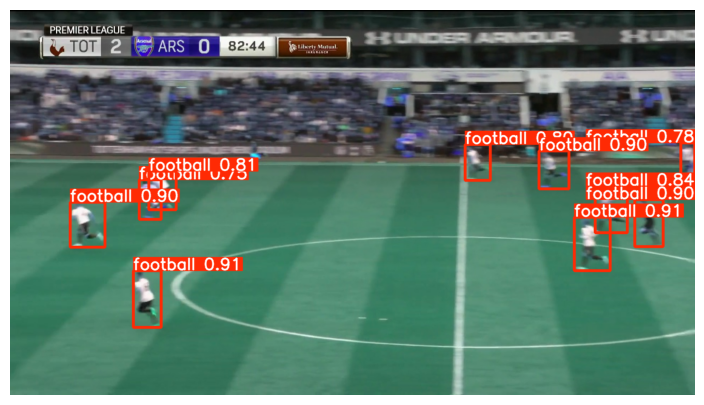

In [13]:
# Path to the best model
model_path = "/kaggle/working/runs/detect/train/weights/best.pt"

model = YOLO(model_path)  # Load the best model

image_folder = "/kaggle/working/yolo_dataset/val/images/"
image_list = glob.glob(image_folder + "*.jpg")

# Select a random image
if len(image_list) > 0:
    test_img = random.choice(image_list)
    print(f"Selected Image: {test_img}")
else:
    print("No images found in the validation folder.")
    test_img = None

if test_img:
    results = model(test_img)

    for r in results:
        im_array = r.plot()
        plt.figure(figsize=(10, 5))
        plt.imshow(im_array)
        plt.axis("off")
        plt.show()


Test on more frames

Processing Image: /kaggle/working/yolo_dataset/val/images/v_ITo3sCnpw_k_c012_000283.jpg

image 1/1 /kaggle/working/yolo_dataset/val/images/v_ITo3sCnpw_k_c012_000283.jpg: 416x736 19 footballs, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 736)


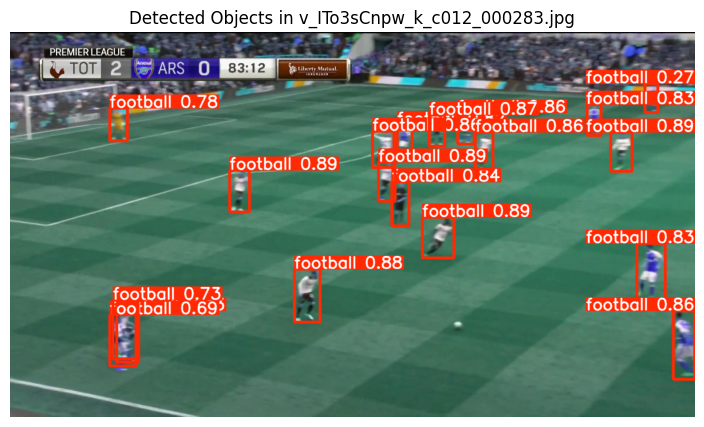

Processing Image: /kaggle/working/yolo_dataset/val/images/v_G-vNjfx1GGc_c008_000347.jpg

image 1/1 /kaggle/working/yolo_dataset/val/images/v_G-vNjfx1GGc_c008_000347.jpg: 416x736 7 footballs, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 736)


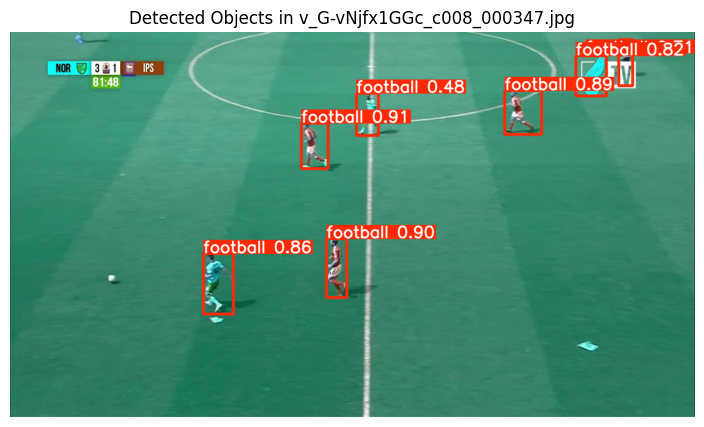

Processing Image: /kaggle/working/yolo_dataset/val/images/v_dw7LOz17Omg_c067_000414.jpg

image 1/1 /kaggle/working/yolo_dataset/val/images/v_dw7LOz17Omg_c067_000414.jpg: 416x736 7 footballs, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 736)


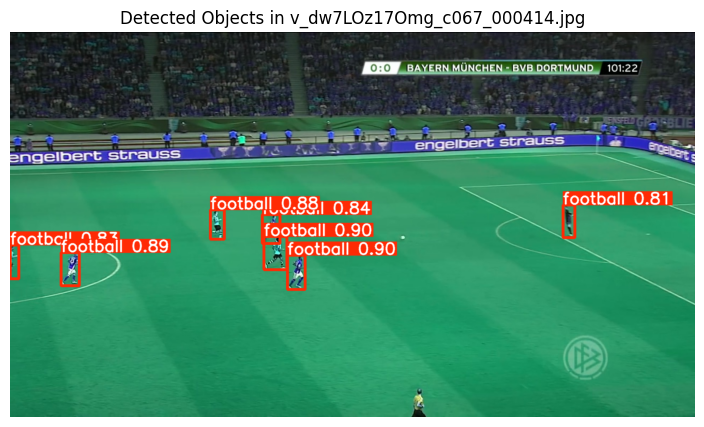

Processing Image: /kaggle/working/yolo_dataset/val/images/v_G-vNjfx1GGc_c004_000036.jpg

image 1/1 /kaggle/working/yolo_dataset/val/images/v_G-vNjfx1GGc_c004_000036.jpg: 416x736 16 footballs, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 736)


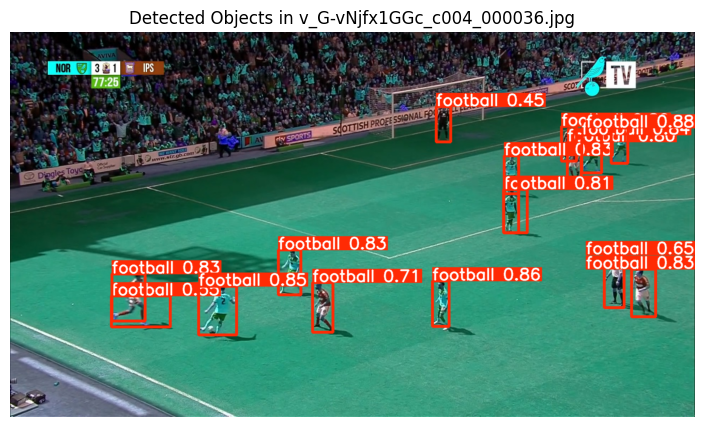

Processing Image: /kaggle/working/yolo_dataset/val/images/v_ITo3sCnpw_k_c011_000231.jpg

image 1/1 /kaggle/working/yolo_dataset/val/images/v_ITo3sCnpw_k_c011_000231.jpg: 416x736 20 footballs, 6.5ms
Speed: 3.2ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 736)


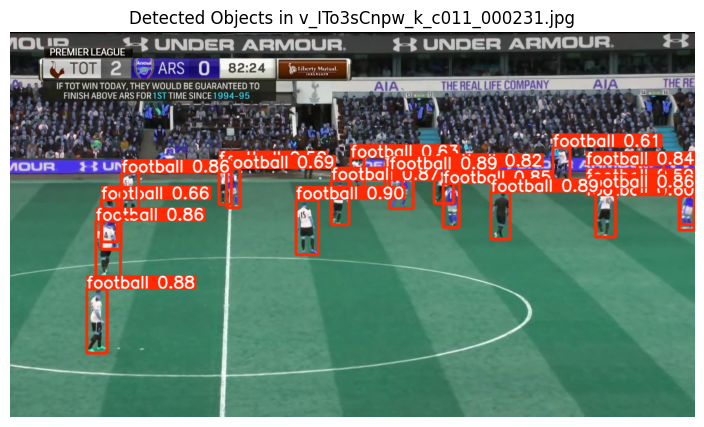

Processing Image: /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c010_000347.jpg

image 1/1 /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c010_000347.jpg: 416x736 8 footballs, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 736)


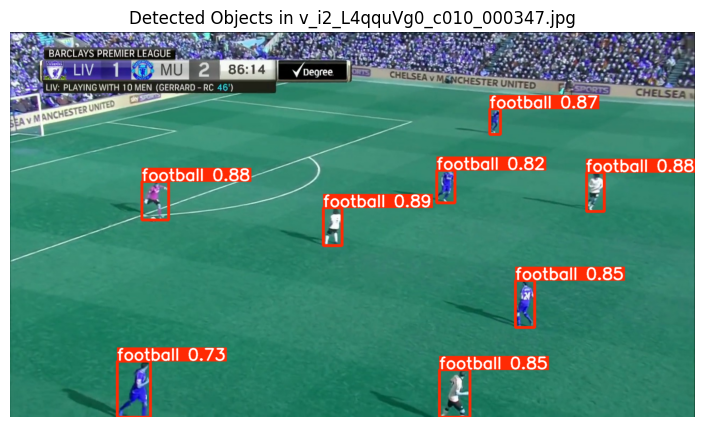

In [14]:
# Path to the trained model
model_path = "/kaggle/working/runs/detect/train/weights/best.pt"

model = YOLO(model_path)  # Load the best model

image_folder = "/kaggle/working/yolo_dataset/val/images/"
image_list = glob.glob(image_folder + "*.jpg")

# Select 6 random images
num_images = min(6, len(image_list))
selected_images = random.sample(image_list, num_images)

for test_img in selected_images:
    print(f"Processing Image: {test_img}")
    
    results = model(test_img)

    for r in results:
        im_array = r.plot()
        plt.figure(figsize=(10, 5))
        plt.imshow(im_array)
        plt.axis("off")
        plt.title(f"Detected Objects in {test_img.split('/')[-1]}")
        plt.show()


In [19]:
print(dir(results))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ap_class_index', 'box', 'class_result', 'confusion_matrix', 'curves', 'curves_results', 'fitness', 'keys', 'maps', 'mean_results', 'names', 'on_plot', 'plot', 'process', 'results_dict', 'save_dir', 'speed', 'task']


In [20]:
print(dir(results.box))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'all_ap', 'ap', 'ap50', 'ap_class_index', 'class_result', 'curves', 'curves_results', 'f1', 'f1_curve', 'fitness', 'map', 'map50', 'map75', 'maps', 'mean_results', 'mp', 'mr', 'nc', 'p', 'p_curve', 'prec_values', 'px', 'r', 'r_curve', 'update']


Show model performance with different measures

In [22]:
# Load the trained YOLOv8 model
model_path = "/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(model_path)

# Evaluate the model on the validation dataset
results = model.val(data="/kaggle/working/yolo_dataset/data.yaml",  # Path to dataset YAML file
                    imgsz=720,
                    batch=16)

print(f"Mean Precision: {results.box.mp:.4f}")
print(f"Mean Recall: {results.box.mr:.4f}")
print(f"mAP@50: {results.box.map50:.4f}")
print(f"mAP@50-95: {results.box.map:.4f}")

class_results = results.box.class_result(0)
print(f"Class 0 - Precision: {class_results[0]:.4f}, Recall: {class_results[1]:.4f}, AP50: {class_results[2]:.4f}, AP: {class_results[3]:.4f}")


WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000499.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000500.jpg: 1


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 567/567 [01:09<00:00,  8.14it/s]


                   all       9058     117024      0.927      0.946      0.953      0.795


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val6
Mean Precision: 0.9269
Mean Recall: 0.9465
mAP@50: 0.9525
mAP@50-95: 0.7953
Class 0 - Precision: 0.9269, Recall: 0.9465, AP50: 0.9525, AP: 0.7953


Here are the metrics :

##  Precision: 0.9269, Recall: 0.9465, AP50: 0.9525, AP: 0.7953